In [1]:
# Imports 

import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import*
from pyspark.sql.types import*

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns

# 4 Loan API


In [2]:
#getting the data via API
url = 'https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json'
response = requests.get(url)
data = response.json()
data

[{'Application_ID': 'LP001002',
  'Gender': 'Male',
  'Married': 'No',
  'Dependents': '0',
  'Education': 'Graduate',
  'Self_Employed': 'No',
  'Credit_History': 1,
  'Property_Area': 'Urban',
  'Income': 'medium',
  'Application_Status': 'Y'},
 {'Application_ID': 'LP001003',
  'Gender': 'Male',
  'Married': 'Yes',
  'Dependents': '1',
  'Education': 'Graduate',
  'Self_Employed': 'No',
  'Credit_History': 1,
  'Property_Area': 'Rural',
  'Income': 'medium',
  'Application_Status': 'N'},
 {'Application_ID': 'LP001005',
  'Gender': 'Male',
  'Married': 'Yes',
  'Dependents': '0',
  'Education': 'Graduate',
  'Self_Employed': 'Yes',
  'Credit_History': 1,
  'Property_Area': 'Urban',
  'Income': 'low',
  'Application_Status': 'Y'},
 {'Application_ID': 'LP001006',
  'Gender': 'Male',
  'Married': 'Yes',
  'Dependents': '0',
  'Education': 'Not Graduate',
  'Self_Employed': 'No',
  'Credit_History': 1,
  'Property_Area': 'Urban',
  'Income': 'low',
  'Application_Status': 'Y'},
 {'Applica

In [3]:
#status code
print(response.status_code)

200


In [4]:
#creating SparkSession to read json file into spark dataframe
spark = SparkSession.builder.master("local[1]").appName("Loan").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/03/01 19:15:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/03/01 19:15:12 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [5]:

loan = spark.sparkContext.parallelize(data)
df_loan = spark.read.json(loan)
df_loan.show(5)

+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|Application_ID|Application_Status|Credit_History|Dependents|   Education|Gender|Income|Married|Property_Area|Self_Employed|
+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|      LP001002|                 Y|             1|         0|    Graduate|  Male|medium|     No|        Urban|           No|
|      LP001003|                 N|             1|         1|    Graduate|  Male|medium|    Yes|        Rural|           No|
|      LP001005|                 Y|             1|         0|    Graduate|  Male|   low|    Yes|        Urban|          Yes|
|      LP001006|                 Y|             1|         0|Not Graduate|  Male|   low|    Yes|        Urban|           No|
|      LP001008|                 Y|             1|         0|    Graduate|  Male|medium|     No|        Urban|           No|


In [6]:
type(df_loan)

pyspark.sql.dataframe.DataFrame

In [7]:
#loading spark dataframe into database

## 5

In [8]:
#importing previously used, cleaned, and merged dataframes
pd_branch = pd.read_csv('./data/pd_branch.csv')
pd_credit =  pd.read_csv('./data/pd_credit.csv')
pd_customers =  pd.read_csv('./data/pd_customers.csv')
pd_cust_and_credit =  pd.read_csv('./data/pd_cust_and_credit.csv')
pd_branch_and_credit =  pd.read_csv('./data/pd_branch_and_credit.csv')

In [9]:
#converting new df_loan to pandas dataframe
pd_loan = df_loan.toPandas()
pd_loan.head()

,Application_ID,Application_Status,Credit_History,Dependents,Education,Gender,Income,Married,Property_Area,Self_Employed
0,LP001002,Y,1,0,Graduate,Male,medium,No,Urban,No
1,LP001003,N,1,1,Graduate,Male,medium,Yes,Rural,No
2,LP001005,Y,1,0,Graduate,Male,low,Yes,Urban,Yes
3,LP001006,Y,1,0,Not Graduate,Male,low,Yes,Urban,No
4,LP001008,Y,1,0,Graduate,Male,medium,No,Urban,No


### 5.2 Application status for self-employees

In [10]:
pd_loan['Application_Status'] = pd_loan['Application_Status'].replace(['N', 'Y'], ['Rejected', 'Approved'])
pd_loan.head()

,Application_ID,Application_Status,Credit_History,Dependents,Education,Gender,Income,Married,Property_Area,Self_Employed
0,LP001002,Approved,1,0,Graduate,Male,medium,No,Urban,No
1,LP001003,Rejected,1,1,Graduate,Male,medium,Yes,Rural,No
2,LP001005,Approved,1,0,Graduate,Male,low,Yes,Urban,Yes
3,LP001006,Approved,1,0,Not Graduate,Male,low,Yes,Urban,No
4,LP001008,Approved,1,0,Graduate,Male,medium,No,Urban,No


In [11]:
#grouping by application status
application_status = pd_loan.groupby(['Application_Status'])['Application_Status'].count()
application_status

Application_Status
Approved    347
Rejected    164
Name: Application_Status, dtype: int64

In [12]:
#grouping by self employee status
self_employed_status = pd_loan.groupby(['Self_Employed'])['Self_Employed'].count()
self_employed_status

Self_Employed
No     441
Yes     70
Name: Self_Employed, dtype: int64

In [13]:
#Application status of self employed
pd_self_employed = pd_loan.loc[(pd_loan.Self_Employed == 'Yes')]
emp_yes = pd_self_employed.groupby(['Application_Status'])['Application_Status'].count()
emp_yes

Application_Status
Approved    46
Rejected    24
Name: Application_Status, dtype: int64

In [14]:
#Self employeed status of applicants
pd_approval = pd_loan.loc[(pd_loan.Application_Status == 'Approved')]
app_approval = pd_approval.groupby(['Self_Employed'])['Self_Employed'].count()
app_approval 

Self_Employed
No     301
Yes     46
Name: Self_Employed, dtype: int64

In [15]:
#showing application status and employee status in single table
fig_checking = pd_loan.groupby(['Application_Status', 'Self_Employed'])['Application_Status'].count()
fig_checking

Application_Status  Self_Employed
Approved            No               301
                    Yes               46
Rejected            No               140
                    Yes               24
Name: Application_Status, dtype: int64

In [16]:
#changing column names for better graphical understanding
emp_response = pd_self_employed.Application_Status.value_counts()
self_emp = emp_response.reset_index()
self_emp.columns = ['Status', 'count']

In [17]:
#changing column names for better graphical understanding
app_response = pd_approval.Self_Employed.value_counts()
app_status = app_response.reset_index()
app_status.columns = ['employed_type', 'count']
app_status['employed_type'] = app_status['employed_type'].replace(['No', 'Yes'], ['Employed_by_others', 'Self_employed'])

In [18]:
app_status

,employed_type,count
0,Employed_by_others,301
1,Self_employed,46


In [19]:
self_emp

,Status,count
0,Approved,46
1,Rejected,24


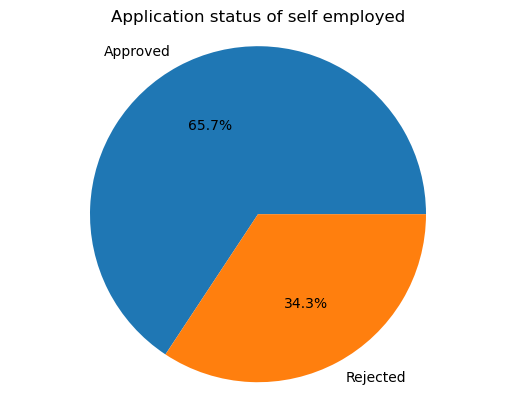

<Figure size 640x480 with 0 Axes>

In [20]:

plt.pie(self_emp['count'], labels=self_emp['Status'], autopct='%1.1f%%')
plt.title('Application status of self employed')
plt.axis('equal')
plt.show()
plt.savefig('./images/self_employ1', dpi=500);

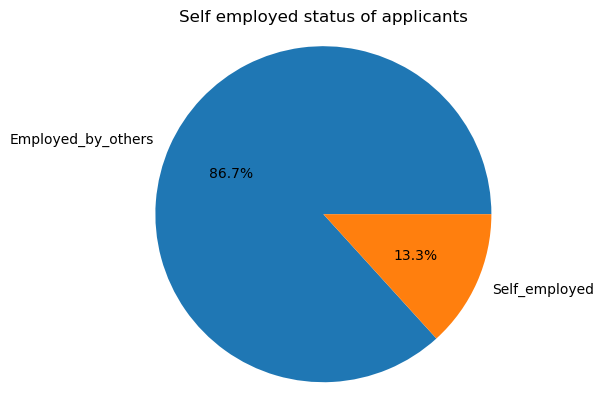

<Figure size 640x480 with 0 Axes>

In [21]:

plt.pie(app_status['count'], labels=app_status['employed_type'], autopct='%1.1f%%')
plt.title('Self employed status of applicants')
plt.axis('equal')
plt.show()
plt.savefig('./images/self_employ2', dpi=500);


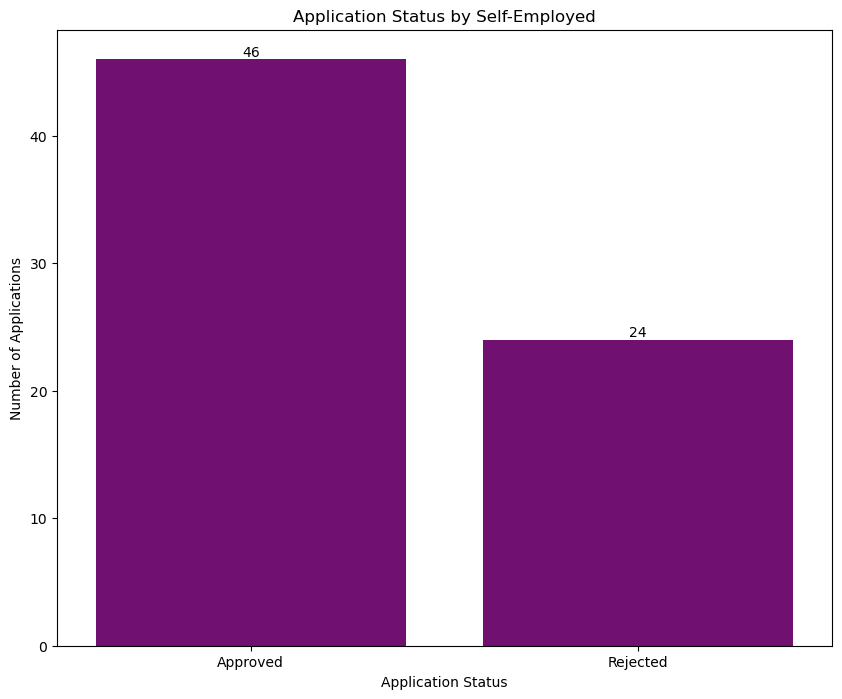

In [22]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.barplot(x='Status', y='count', data=self_emp, color='purple')
plt.title('Application Status by Self-Employed')
plt.xlabel('Application Status')
plt.ylabel('Number of Applications')
ax.bar_label(ax.containers[0])
plt.savefig('./images/self_employ3', dpi=500);

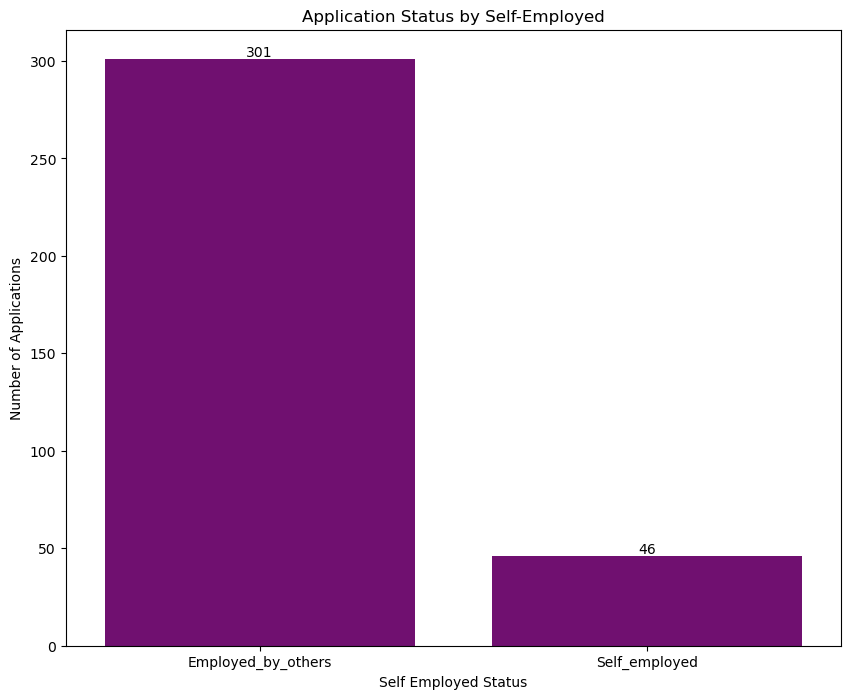

In [23]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.barplot(x='employed_type', y='count', data=app_status, color='purple')
plt.title('Application Status by Self-Employed')
plt.xlabel('Self Employed Status')
plt.ylabel('Number of Applications')
ax.bar_label(ax.containers[0])
plt.savefig('./images/self_employ4', dpi=500);

### 5.2 Application status for married men  

In [24]:
fig_checking2 = pd_loan.groupby(['Gender', 'Married', 'Application_Status'])['Application_Status'].count()
fig_checking2

Gender  Married  Application_Status
Female  No       Approved               40
                 Rejected               26
        Yes      Approved               17
                 Rejected                8
Male    No       Approved               71
                 Rejected               43
        Yes      Approved              219
                 Rejected               87
Name: Application_Status, dtype: int64

In [25]:
pd_married_male = pd_loan.loc[(pd_loan.Gender == 'Male') & (pd_loan.Married == 'Yes')]
pd_married_men = pd_married_male.groupby(['Application_Status'])['Application_Status'].count()
pd_married_men


Application_Status
Approved    219
Rejected     87
Name: Application_Status, dtype: int64

In [26]:
app_status_married_men = pd_married_male.Application_Status.value_counts()
married_men = app_status_married_men.reset_index()
married_men.columns = ['Status', 'count']

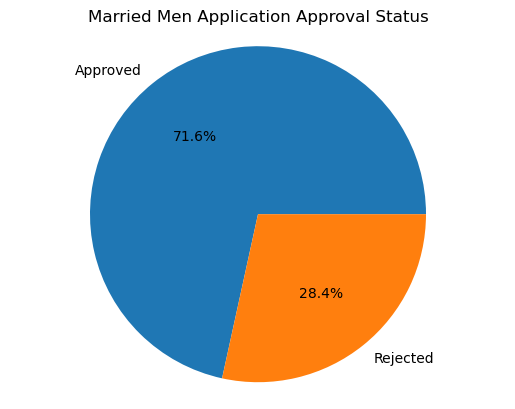

<Figure size 640x480 with 0 Axes>

In [27]:
plt.pie(married_men['count'], labels=married_men['Status'], autopct='%1.1f%%')
plt.title('Married Men Application Approval Status')
plt.axis('equal')
plt.show()
plt.savefig('./images/married_men', dpi=500);

### 5.2 Top 3 Months with largest transaction data  

In [28]:
pd_credit.columns

Index(['BRANCH_CODE', 'CUST_CC_NO', 'CUST_SSN', 'DAY', 'MONTH',
       'TRANSACTION_ID', 'TRANSACTION_TYPE', 'TRANSACTION_VALUE', 'YEAR',
       'TIMEID'],
      dtype='object')

In [29]:
print(pd_credit.sort_values(by=['TIMEID'], ascending=False).head(2))
print(pd_credit.sort_values(by=['TIMEID'], ascending=True).head(2))

       BRANCH_CODE        CUST_CC_NO   CUST_SSN  DAY  MONTH  TRANSACTION_ID  \
13787           43  4210653317392678  123457286   28     12           13788   
7422            75  4210653388841064  123458478   28     12            7423   

      TRANSACTION_TYPE  TRANSACTION_VALUE  YEAR      TIMEID  
13787        Education              87.58  2018  2018-12-28  
7422             Bills              86.33  2018  2018-12-28  
       BRANCH_CODE        CUST_CC_NO   CUST_SSN  DAY  MONTH  TRANSACTION_ID  \
33193          123  4210653362839417  123453697    1      1           33194   
43679           15  4210653368958546  123451540    1      1           43680   

      TRANSACTION_TYPE  TRANSACTION_VALUE  YEAR      TIMEID  
33193       Healthcare              23.30  2018  2018-01-01  
43679              Gas              18.18  2018  2018-01-01  


In [30]:
monthly_transactions = pd_credit.groupby(['MONTH'])['TRANSACTION_VALUE'].sum()
monthly_transactions

MONTH
1     196568.87
2     201086.67
3     196488.59
4     194203.25
5     201310.26
6     195468.74
7     201199.35
8     196453.41
9     196069.44
10    202583.89
11    200549.36
12    201251.08
Name: TRANSACTION_VALUE, dtype: float64

In [31]:
month_count = monthly_transactions.reset_index()
month_count.columns = ['month', 'total_transactions']
month_count

,month,total_transactions
0,1,196568.87
1,2,201086.67
2,3,196488.59
3,4,194203.25
4,5,201310.26
5,6,195468.74
6,7,201199.35
7,8,196453.41
8,9,196069.44
9,10,202583.89


In [32]:
month_count.dtypes

month                   int64
total_transactions    float64
dtype: object

In [33]:
month_count['month'] = month_count['month'].apply(str)
month_count['month'] = month_count['month'].replace(['1','2','3','4','5','6','7','8','9','10','11','12'], 
                          ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec'])
#month_count.loc[:,'total_transactions'] ='$'+ month_count['total_transactions'].map('{:,.0f}'.format)
month_count

,month,total_transactions
0,Jan,196568.87
1,Feb,201086.67
2,Mar,196488.59
3,Apr,194203.25
4,May,201310.26
5,Jun,195468.74
6,Jul,201199.35
7,Aug,196453.41
8,Sept,196069.44
9,Oct,202583.89


In [34]:
top_3_months = month_count.sort_values(by=['total_transactions'], ascending=False).head(3)
top_3_months

,month,total_transactions
9,Oct,202583.89
4,May,201310.26
11,Dec,201251.08


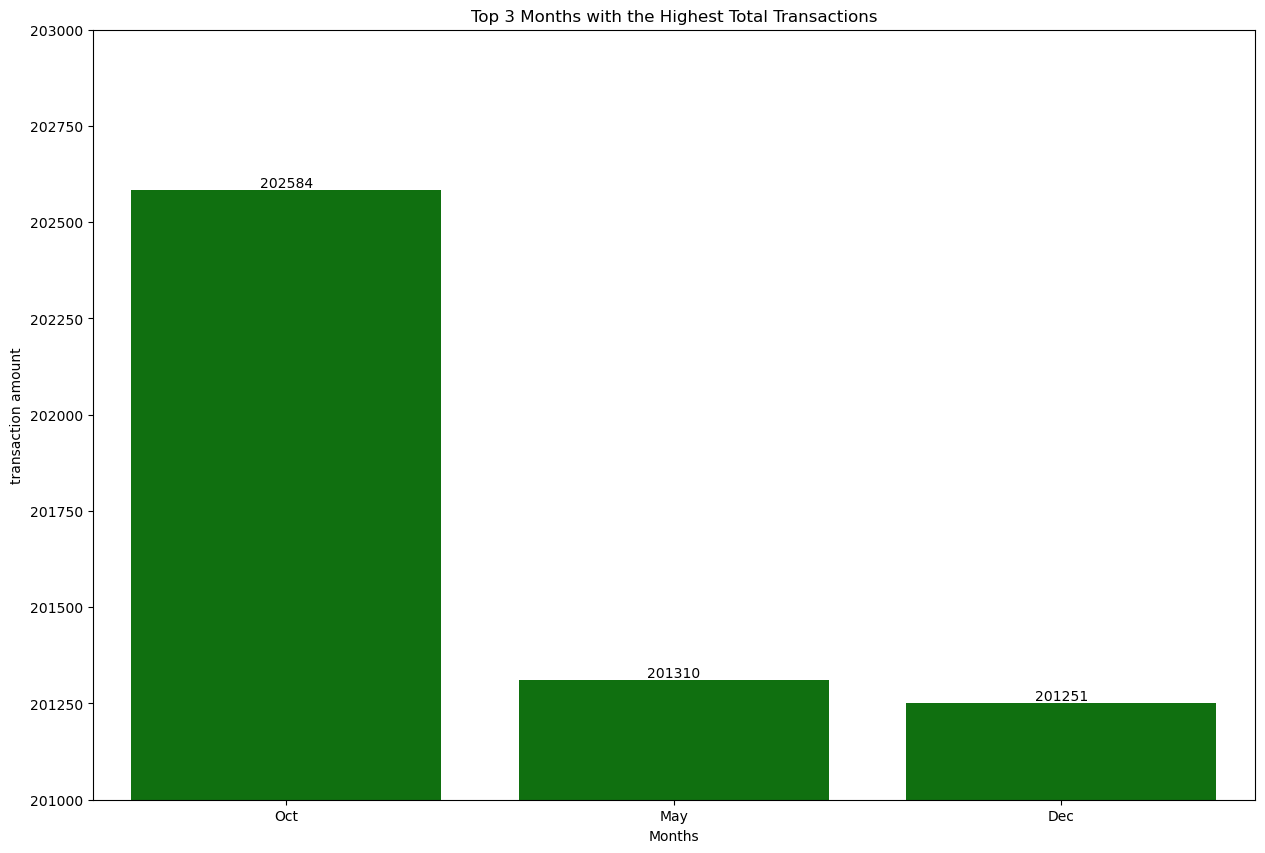

In [35]:
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.barplot(x='month', y='total_transactions', data=top_3_months, color='green')
plt.title('Top 3 Months with the Highest Total Transactions')
plt.xlabel('Months')
plt.ylabel('transaction amount')
plt.ylim(201000, 203000)
ax.bar_label(ax.containers[0])
plt.savefig('./images/top3months', dpi=500);

### 5.2 Top Branches for Healthcare transactions

In [36]:
healthcare_trans_pd = pd_branch_and_credit.loc[(pd_branch_and_credit.TRANSACTION_TYPE == 'Healthcare')]
healthcare_by_branch = healthcare_trans_pd.groupby(['BRANCH_CODE'])['TRANSACTION_VALUE'].sum()
healthcare_by_branch

BRANCH_CODE
1.0      2920.15
2.0      3284.31
3.0      3353.55
4.0      2436.80
5.0      2736.69
          ...   
175.0    3341.57
178.0    2957.41
180.0    2344.08
188.0    2869.18
192.0    1960.35
Name: TRANSACTION_VALUE, Length: 114, dtype: float64

In [37]:
healthcare_total_pd = healthcare_by_branch.reset_index()
healthcare_total_pd

,BRANCH_CODE,TRANSACTION_VALUE
0,1.0,2920.15
1,2.0,3284.31
2,3.0,3353.55
3,4.0,2436.80
4,5.0,2736.69
...,...,...
109,175.0,3341.57
110,178.0,2957.41
111,180.0,2344.08
112,188.0,2869.18


In [38]:
healthcare_tran_df = pd_branch_and_credit[['BRANCH_CODE', 'TRANSACTION_VALUE', 'BRANCH_NAME']].copy()
healthcare_tran_df

,BRANCH_CODE,TRANSACTION_VALUE,BRANCH_NAME
0,1.0,53.03,Example Bank
1,1.0,58.78,Example Bank
2,1.0,5.49,Example Bank
3,1.0,42.26,Example Bank
4,1.0,6.65,Example Bank
...,...,...,...
46690,192.0,62.73,Example Bank
46691,192.0,65.54,Example Bank
46692,192.0,92.44,Example Bank
46693,192.0,34.91,Example Bank


In [39]:
pd_branch['BRANCH_NAME'].value_counts()

Example Bank    115
Name: BRANCH_NAME, dtype: int64

In [40]:
top_branch_for_healthcare_trans = healthcare_total_pd.sort_values(by=['TRANSACTION_VALUE'], ascending=False).head(1)
top_branch_for_healthcare_trans

,BRANCH_CODE,TRANSACTION_VALUE
22,25.0,4370.18


In [41]:
top3_branches_for_healthcare_trans = healthcare_total_pd.sort_values(by=['TRANSACTION_VALUE'], ascending=False).head(3)
top3_branches_for_healthcare_trans

,BRANCH_CODE,TRANSACTION_VALUE
22,25.0,4370.18
53,60.0,4072.04
69,83.0,4003.37


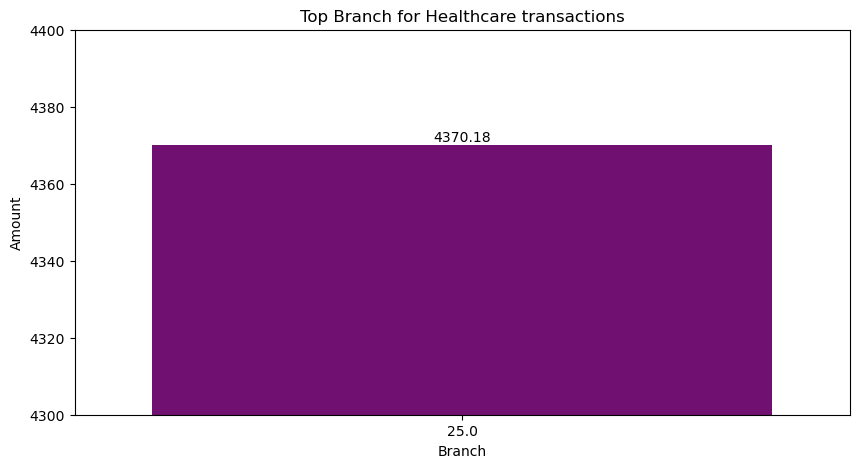

In [42]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.barplot(x='BRANCH_CODE', y='TRANSACTION_VALUE', data=top_branch_for_healthcare_trans, color='purple')
plt.title('Top Branch for Healthcare transactions')
plt.xlabel('Branch')
plt.ylabel('Amount')
plt.ylim(4300, 4400)
ax.bar_label(ax.containers[0])
plt.savefig('./images/top_branch_healthcare', dpi=500);

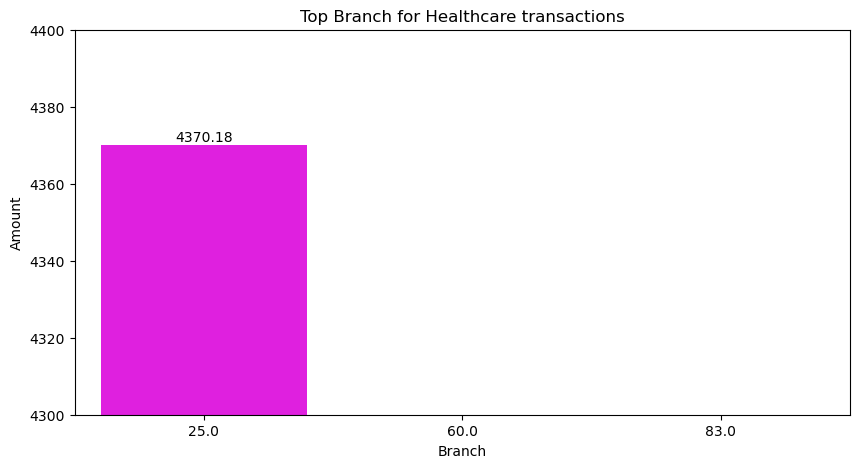

In [43]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.barplot(x='BRANCH_CODE', y='TRANSACTION_VALUE', data=top3_branches_for_healthcare_trans, color='magenta')
plt.title('Top Branch for Healthcare transactions')
plt.xlabel('Branch')
plt.ylabel('Amount')
plt.ylim(4300, 4400)
ax.bar_label(ax.containers[0])
plt.savefig('./images/top3_branches_healthcare', dpi=500);

In [44]:
spark.stop()

23/03/01 19:15:24 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:103)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1005)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:212)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2019)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.runAndReset(FutureTask.java:308)
	at java.util.concurrent.ScheduledThreadPoolExecutor$ScheduledFutureTask.access$301(ScheduledThreadPoolExecutor.java:1